# Assignment 2

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `FirstnameLastname.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it by adding the source of the code as a comment in the first line of the code cell.
- In real life clients can give unclear goals or requirements. So, if the instructions seem vague, use common sense to make reasonable assumptions.

# Task 1: [Where's Waldo?](https://www.wikihow.com/Find-Waldo) (35 points)

## Fingerprinting
Browser fingerprinting is a technique used to identify and track individuals based on unique characteristics of their web browser configuration. These characteristics can include the browser type, version, installed plugins, and screen resolution, among others. By combining these attributes, websites can create a digital fingerprint that can be used to track user behavior across multiple sites, even if they clear their cookies or use different devices. This has raised concerns about privacy and the potential for this technology to be used for targeted advertising, surveillance, and other purposes.

[Read more]([Fingerprinting](https://datadome.co/learning-center/browser-fingerprinting-techniques/))

##  What you need to do
For this task, you are required to build a fully connect feed-forward ANN model
for a classification problem.

For the given data, you need do proper data preprocessing, data analysis,
design the ANN model, then fine-tune your model architecture.

For evaluating your model, do $ 80/20 $ train test split.

### Learning Objectives

- Select and implement suitable data preprocessing techniques. 10%
- Identify the appropriate classification approach for a given problem. 20%
- Apply ANNs to solve a classification problem (basic training, validation, testing -- without fine tuning). 50%
- Fine-tune to determine the optimal model architecture. 20%


### Data
You will be working with the data in `Task_1.csv` for identifying waldo (the user with `user_id=0`) 

The columns include:
 - browser
 - os
 - locale
 - user_id
 - location
 - sites
 - time
 - date

After training, evaluate you model by print [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
on your test set. 

Then predicting each user in `task_1_verify.csv` whether it's Waldo or not. Your output should look like the following:

`row_idx: is_waldo`, notice if the user is waldo your output should be 1

``` 
0: 1
1: 0
2: 0
3: 1
4: 1
...
```



In [22]:
import datetime

import pandas as pd
from sklearn.model_selection import train_test_split

from keras import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.metrics import Recall, Precision
import keras.backend as K
from sklearn.preprocessing import OneHotEncoder

RANDOM_STATE = 123
VERBOSITY = 1


In [61]:

def preprocess_y(df):
    y = df.pop("user_id")
    y = y.apply(lambda x: 1 if x == 0 else 0)
    y = pd.DataFrame(y)

    return y

def preprocess_X(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    def scale_col(col: pd.Series) -> pd.Series:
        from sklearn.preprocessing import MinMaxScaler

        scaler = MinMaxScaler()

        col_2d = col.values.reshape(-1, 1)
        scaled_col = scaler.fit_transform(col_2d)
        return scaled_col.reshape(-1)


    # Convert "time" column to float, and scale it
    time_float = pd.to_timedelta(df["time"])
    time_float = scale_col(time_float)
    df["time"] = time_float

    # Convert "date" column to int, and scale it
    date_int = df["date"].apply(lambda x: datetime.date.fromisoformat(x).toordinal())
    date_int = scale_col(date_int)
    df["date"] = date_int

    cols_to_drop = [
        # "time",
        # "date",
        "sites"
    ]
    X = df.drop(columns=cols_to_drop)

    if "index" in X.columns:
        X = X.drop(columns=["index"])

    return X

def preprocess(fpath: str, with_y=True):
    df = pd.read_csv(fpath)

    if with_y:
        y = preprocess_y(df)
        X = preprocess_X(df)
        return X, y
    else:
        X = preprocess_X(df)
        return X

def onehot_encode(X: pd.DataFrame) -> pd.DataFrame:
    print(X.columns)

    X_skip = X[["date", "time"]]
    encode_cols=["browser", "os", "locale", "location"]
    X_encode = X[encode_cols]

    encoder = OneHotEncoder()
    encoder.fit(X_encode)
    np_array = encoder.transform(X_encode).toarray()
    feat_columns = encoder.get_feature_names_out(encode_cols)

    res_df = pd.DataFrame(np_array, columns=feat_columns)

    return res_df.assign(**{"time": X_skip["time"], "date": X_skip["date"]})
    # return pd.concat([res_df, X_skip], axis=0, ignore_index=True)

print("Preprocessing...")
X, y = preprocess("task1.csv")

print("Encoding...")

X = onehot_encode(X)
X_df_columns = X.columns  # will be needed further

X = np.array(X)
y = np.array(y)

print("Completed encoding")


Preprocessing...
Encoding...
Index(['browser', 'os', 'locale', 'location', 'time', 'date'], dtype='object')
Completed encoding


In [30]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train.shape, X_test.shape


((16320, 58), (4081, 58))

In [31]:

def my_f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val


def build_model(neurons_cnt=16, layers_cnt=1, dropout_prob=0.5):
    model = Sequential()

    model.add(Dense(neurons_cnt, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(dropout_prob))

    for i in range(layers_cnt):
        model.add(Dense(neurons_cnt, activation='relu'))
        model.add(Dropout(dropout_prob))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        my_f1_score,
        'accuracy',
        Precision(),
        Recall(),
    ]
)

    return model


model = build_model()



In [33]:

VALIDATION_RATIO = 0.2
BATCH_SIZE = 128
EPOCHS = 200

def fit_model(model, X, y, with_es=False):

    early_stopping = EarlyStopping(
        patience=5,
        # min_delta=0.00001,
        restore_best_weights=True
    )

    print("model.fit")
    return model.fit(
        X, y,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_RATIO,
        verbose=VERBOSITY,
        callbacks=[early_stopping] if with_es else []
    )


history = fit_model(model, X_train, y_train)



model.fit
Epoch 1/200
102/102 [==============================] - 0s 3ms/step - loss: 0.0043 - my_f1_score: 0.8992 - accuracy: 0.9990 - precision_1: 0.9802 - recall_1: 0.9688 - val_loss: 0.0052 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_1: 0.9420 - val_recall_1: 1.0000
Epoch 2/200
102/102 [==============================] - 0s 3ms/step - loss: 0.0049 - my_f1_score: 0.8793 - accuracy: 0.9991 - precision_1: 0.9586 - recall_1: 0.9961 - val_loss: 0.0049 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_1: 0.9420 - val_recall_1: 1.0000
Epoch 3/200
102/102 [==============================] - 0s 3ms/step - loss: 0.0054 - my_f1_score: 0.8886 - accuracy: 0.9988 - precision_1: 0.9651 - recall_1: 0.9727 - val_loss: 0.0052 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_1: 0.9420 - val_recall_1: 1.0000
Epoch 4/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0037 - my_f1_score: 0.8824 - accuracy: 0.9991 - precision_1: 0.9729 - 

102/102 [==============================] - 0s 3ms/step - loss: 0.0040 - my_f1_score: 0.9020 - accuracy: 0.9987 - precision_1: 0.9799 - recall_1: 0.9531 - val_loss: 0.0059 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_1: 0.9420 - val_recall_1: 1.0000
Epoch 31/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0046 - my_f1_score: 0.9034 - accuracy: 0.9991 - precision_1: 0.9766 - recall_1: 0.9766 - val_loss: 0.0054 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_1: 0.9420 - val_recall_1: 1.0000
Epoch 32/200
102/102 [==============================] - 1s 6ms/step - loss: 0.0038 - my_f1_score: 0.8858 - accuracy: 0.9990 - precision_1: 0.9802 - recall_1: 0.9688 - val_loss: 0.0057 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_1: 0.9420 - val_recall_1: 1.0000
Epoch 33/200
102/102 [==============================] - 0s 3ms/step - loss: 0.0042 - my_f1_score: 0.8752 - accuracy: 0.9990 - precision_1: 0.9691 - recall_1: 0.9805 - 

102/102 [==============================] - 0s 3ms/step - loss: 0.0055 - my_f1_score: 0.8765 - accuracy: 0.9989 - precision_1: 0.9689 - recall_1: 0.9727 - val_loss: 0.0052 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_1: 0.9420 - val_recall_1: 1.0000
Epoch 60/200
102/102 [==============================] - 0s 3ms/step - loss: 0.0039 - my_f1_score: 0.9193 - accuracy: 0.9989 - precision_1: 0.9763 - recall_1: 0.9648 - val_loss: 0.0053 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_1: 0.9420 - val_recall_1: 1.0000
Epoch 61/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0053 - my_f1_score: 0.9029 - accuracy: 0.9989 - precision_1: 0.9689 - recall_1: 0.9727 - val_loss: 0.0055 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_1: 0.9420 - val_recall_1: 1.0000
Epoch 62/200
102/102 [==============================] - 1s 5ms/step - loss: 0.0039 - my_f1_score: 0.8772 - accuracy: 0.9991 - precision_1: 0.9803 - recall_1: 0.9727 - 

102/102 [==============================] - 0s 3ms/step - loss: 0.0049 - my_f1_score: 0.9160 - accuracy: 0.9984 - precision_1: 0.9644 - recall_1: 0.9531 - val_loss: 0.0057 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_1: 0.9420 - val_recall_1: 1.0000
Epoch 89/200
102/102 [==============================] - 0s 3ms/step - loss: 0.0045 - my_f1_score: 0.8721 - accuracy: 0.9986 - precision_1: 0.9648 - recall_1: 0.9648 - val_loss: 0.0059 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_1: 0.9420 - val_recall_1: 1.0000
Epoch 90/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0044 - my_f1_score: 0.8619 - accuracy: 0.9985 - precision_1: 0.9721 - recall_1: 0.9531 - val_loss: 0.0064 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_1: 0.9420 - val_recall_1: 1.0000
Epoch 91/200
102/102 [==============================] - 1s 6ms/step - loss: 0.0042 - my_f1_score: 0.9273 - accuracy: 0.9989 - precision_1: 0.9689 - recall_1: 0.9727 - 

102/102 [==============================] - 1s 6ms/step - loss: 0.0047 - my_f1_score: 0.9085 - accuracy: 0.9987 - precision_1: 0.9686 - recall_1: 0.9648 - val_loss: 0.0051 - val_my_f1_score: 0.8659 - val_accuracy: 0.9991 - val_precision_1: 0.9559 - val_recall_1: 1.0000
Epoch 118/200
102/102 [==============================] - 1s 5ms/step - loss: 0.0058 - my_f1_score: 0.8645 - accuracy: 0.9984 - precision_1: 0.9608 - recall_1: 0.9570 - val_loss: 0.0047 - val_my_f1_score: 0.8659 - val_accuracy: 0.9991 - val_precision_1: 0.9559 - val_recall_1: 1.0000
Epoch 119/200
102/102 [==============================] - 1s 5ms/step - loss: 0.0053 - my_f1_score: 0.8668 - accuracy: 0.9988 - precision_1: 0.9651 - recall_1: 0.9727 - val_loss: 0.0049 - val_my_f1_score: 0.8659 - val_accuracy: 0.9991 - val_precision_1: 0.9559 - val_recall_1: 1.0000
Epoch 120/200
102/102 [==============================] - 0s 5ms/step - loss: 0.0052 - my_f1_score: 0.8672 - accuracy: 0.9984 - precision_1: 0.9681 - recall_1: 0.9492

Epoch 146/200
102/102 [==============================] - 0s 5ms/step - loss: 0.0041 - my_f1_score: 0.8903 - accuracy: 0.9995 - precision_1: 0.9770 - recall_1: 0.9961 - val_loss: 0.0062 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_1: 0.9420 - val_recall_1: 1.0000
Epoch 147/200
102/102 [==============================] - 0s 5ms/step - loss: 0.0034 - my_f1_score: 0.9090 - accuracy: 0.9992 - precision_1: 0.9731 - recall_1: 0.9883 - val_loss: 0.0059 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_1: 0.9420 - val_recall_1: 1.0000
Epoch 148/200
102/102 [==============================] - 1s 5ms/step - loss: 0.0038 - my_f1_score: 0.8943 - accuracy: 0.9991 - precision_1: 0.9729 - recall_1: 0.9805 - val_loss: 0.0060 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_1: 0.9420 - val_recall_1: 1.0000
Epoch 149/200
102/102 [==============================] - 1s 6ms/step - loss: 0.0038 - my_f1_score: 0.9195 - accuracy: 0.9990 - precision_1: 0.9728 - re

Epoch 175/200
102/102 [==============================] - 1s 5ms/step - loss: 0.0059 - my_f1_score: 0.8327 - accuracy: 0.9989 - precision_1: 0.9617 - recall_1: 0.9805 - val_loss: 0.0049 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_1: 0.9420 - val_recall_1: 1.0000
Epoch 176/200
102/102 [==============================] - 0s 3ms/step - loss: 0.0059 - my_f1_score: 0.8794 - accuracy: 0.9982 - precision_1: 0.9605 - recall_1: 0.9492 - val_loss: 0.0051 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_1: 0.9420 - val_recall_1: 1.0000
Epoch 177/200
102/102 [==============================] - 0s 4ms/step - loss: 0.0046 - my_f1_score: 0.9054 - accuracy: 0.9987 - precision_1: 0.9761 - recall_1: 0.9570 - val_loss: 0.0051 - val_my_f1_score: 0.8659 - val_accuracy: 0.9991 - val_precision_1: 0.9559 - val_recall_1: 1.0000
Epoch 178/200
102/102 [==============================] - 1s 5ms/step - loss: 0.0035 - my_f1_score: 0.8981 - accuracy: 0.9992 - precision_1: 0.9842 - re

In [43]:
test_loss, test_f1, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)

print(test_loss, test_f1, test_accuracy, test_precision, test_recall)

128/128 [==============================] - 1s 4ms/step - loss: 0.0012 - my_f1_score: 0.4687 - accuracy: 0.9998 - precision_1: 0.9875 - recall_1: 1.0000
0.0012493579415604472 0.4687499701976776 0.9997549653053284 0.987500011920929 1.0


In [44]:
from sklearn.metrics import classification_report

# evaluate the model without fine tuning
y_pred = model.predict(X_test, verbose=VERBOSITY) > 0.5
print(classification_report(y_test, y_pred))


128/128 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4002
           1       0.99      1.00      0.99        79

    accuracy                           1.00      4081
   macro avg       0.99      1.00      1.00      4081
weighted avg       1.00      1.00      1.00      4081



In [45]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

model = KerasClassifier(build_fn=build_model, verbose=VERBOSITY)

param_grid = {
    'neurons_cnt': [16, 32, 64],
    'layers_cnt': [1, 2, 3],
    'dropout_prob' : [0.0, 0.1, 0.2],
}

grid_search_cv = GridSearchCV(model, param_grid=param_grid, cv=3, scoring='f1', verbose=VERBOSITY)
gs_result = grid_search_cv.fit(X_train, y_train, verbose=2)


/tmp/ipykernel_12576/1518121525.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model, verbose=VERBOSITY)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
340/340 - 2s - loss: 0.1127 - my_f1_score: 0.0000e+00 - accuracy: 0.9802 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - 2s/epoch - 5ms/step
170/170 [==============================] - 0s 1ms/step
340/340 - 2s - loss: 0.2385 - my_f1_score: 0.0067 - accuracy: 0.9248 - precision_3: 0.0263 - recall_3: 0.0829 - 2s/epoch - 5ms/step
170/170 [==============================] - 0s 1ms/step
340/340 - 2s - loss: 0.1520 - my_f1_score: 0.0000e+00 - accuracy: 0.9768 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - 2s/epoch - 5ms/step
170/170 [==============================] - 0s 1ms/step
340/340 - 2s - loss: 0.0785 - my_f1_score: 0.0635 - accuracy: 0.9832 - precision_5: 1.0000 - recall_5: 0.1368 - 2s/epoch - 5ms/step
170/170 [==============================] - 0s 2ms/step
340/340 - 2s - loss: 0.0868 - my_f1_score: 0.0069 - accuracy: 0.9802 - precision_6: 0.1875 - recall_6: 0.0146 - 2s/epoch - 5ms/step
170/170 [==========================

170/170 [==============================] - 0s 1ms/step
340/340 - 2s - loss: 0.0691 - my_f1_score: 0.0608 - accuracy: 0.9812 - precision_45: 0.5000 - recall_45: 0.1415 - 2s/epoch - 5ms/step
170/170 [==============================] - 0s 2ms/step
340/340 - 2s - loss: 0.0735 - my_f1_score: 0.1055 - accuracy: 0.9747 - precision_46: 0.3239 - recall_46: 0.2044 - 2s/epoch - 5ms/step
170/170 [==============================] - 0s 1ms/step
340/340 - 2s - loss: 0.1246 - my_f1_score: 0.0000e+00 - accuracy: 0.9790 - precision_47: 0.0000e+00 - recall_47: 0.0000e+00 - 2s/epoch - 6ms/step
170/170 [==============================] - 0s 2ms/step
340/340 - 2s - loss: 0.1362 - my_f1_score: 5.8824e-04 - accuracy: 0.9733 - precision_48: 0.0115 - recall_48: 0.0049 - 2s/epoch - 6ms/step
170/170 [==============================] - 0s 2ms/step
340/340 - 2s - loss: 0.1716 - my_f1_score: 0.0041 - accuracy: 0.9547 - precision_49: 0.0411 - recall_49: 0.0533 - 2s/epoch - 5ms/step
170/170 [==============================

In [46]:
print("Best F1:", round(gs_result.best_score_, 2))
print(gs_result.best_params_)


Best F1: 0.97
{'dropout_prob': 0.1, 'layers_cnt': 3, 'neurons_cnt': 64}


In [47]:

# Now build model with best hyperparameters
best_model = build_model(**gs_result.best_params_)

fit_model(best_model, X_train, y_train, with_es=True)

model.fit
Epoch 1/200
102/102 [==============================] - 2s 6ms/step - loss: 0.1320 - my_f1_score: 0.0010 - accuracy: 0.9770 - precision_84: 0.0417 - recall_84: 0.0078 - val_loss: 0.0325 - val_my_f1_score: 0.0000e+00 - val_accuracy: 0.9801 - val_precision_84: 0.0000e+00 - val_recall_84: 0.0000e+00
Epoch 2/200
102/102 [==============================] - 1s 6ms/step - loss: 0.0215 - my_f1_score: 0.2108 - accuracy: 0.9845 - precision_84: 0.9492 - recall_84: 0.2188 - val_loss: 0.0127 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_84: 0.9420 - val_recall_84: 1.0000
Epoch 3/200
102/102 [==============================] - 1s 6ms/step - loss: 0.0077 - my_f1_score: 0.8932 - accuracy: 0.9982 - precision_84: 0.9363 - recall_84: 0.9766 - val_loss: 0.0044 - val_my_f1_score: 0.8582 - val_accuracy: 0.9988 - val_precision_84: 0.9420 - val_recall_84: 1.0000
Epoch 4/200
102/102 [==============================] - 0s 5ms/step - loss: 0.0047 - my_f1_score: 0.8939 - accuracy: 0.9988 

In [48]:
y_pred = best_model.predict(X_test, verbose=VERBOSITY) > 0.5
print(classification_report(y_test, y_pred))


128/128 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4002
           1       0.96      1.00      0.98        79

    accuracy                           1.00      4081
   macro avg       0.98      1.00      0.99      4081
weighted avg       1.00      1.00      1.00      4081



In [64]:

# === VERIFY ===

X_verify = preprocess("task_1_verify.csv", with_y=False)
X_verify = onehot_encode(X_verify)


Index(['browser', 'os', 'locale', 'location', 'time', 'date'], dtype='object')


In [65]:
missing_cols = list(
    set(X_df_columns) - set(X_verify.columns)
)

# Assign missing columns to zero
X_verify.loc[:, missing_cols] = 0

# Re-sort by initial test data columns
X_verify = X_verify[X_df_columns]

X_verify = np.array(X_verify)


In [66]:
y_pred = best_model.predict(X_verify, verbose=VERBOSITY) > 0.5

for i in range(len(y_pred)):
    print(f"{i}: {int(y_pred[i][0])}")

2/2 [==============================] - 0s 2ms/step
0: 0
1: 0
2: 0
3: 0
4: 0
5: 0
6: 0
7: 0
8: 0
9: 0
10: 0
11: 0
12: 0
13: 0
14: 0
15: 0
16: 0
17: 0
18: 0
19: 0
20: 0
21: 0
22: 0
23: 0
24: 0
25: 0
26: 0
27: 0
28: 0
29: 0
30: 0
31: 1
32: 1
33: 1
34: 1
35: 1


### Questions
1. Did you find any usefull insights from your data analysis?
    - *"sites" column seems difficult to handle and also very unique, so I've dropped it out*
2. What preprocessing techniques did you use? Why?
    - *I used `OneHotEncoder` to encode categorical columns*
    - *I used `MinMaxScaler` to scale "date" and "time" columns
3. Describe the fine-tuning process and how you reached your model architecture.
    - I used `GridSearchCV` to search for best
        - count of neurons in layers,
        - count of hidden layers,
        - and dropout probability
      - 'num_layers': number of hidden layers,
      - 'dropout' : randomly setting activation of neurons to zero
4. Which metric did you try to optemize for this task? Why?
    - I used `F1 score` because our dataset is unbalanced, in combination with
        - accuracy
        - precision
        - recall

# Task 2: Fingerprint Recognition (50 points)
Fingerprint recognition is a highly accurate and reliable biometric technology that is used for identification and authentication purposes. By analyzing the unique patterns and ridges on an individual's fingerprint, it is possible to verify their identity with a high degree of confidence. This technology is widely used in law enforcement, border control, and access control systems, as well as in mobile devices and payment systems, to ensure secure and reliable identification and authentication.

In this task you will be doing a simplified version of Fingerprint ID, which is just identifying which finger is used in the image

## What you need to do

For this task, you will be doing image classification:
- Build a CNN model for image classification.
- Estimate the speed of inference of your model

For the given data, you need to do proper data preprocessing, augmentation, and data loaders.

Then fine-tune your model architecture to achieve the highest accuracy.

### Learning Objectives

- Select and implement suitable data preprocessing techniques. 10%
- Use literature (any paper on the use of CNN for fingerprinting and cite it) to choose an architecture. 10%
- Apply CNNs to solve an image classification problem (basic training, validation, testing -- without fine tuning). 40%
- Fine-tune your model to improve performance. 20%
- Use of data augmentation to improve model’s performance. 20%
- Explore beyond data augmentation find techniques to improve model’s performance and use them. 15%(bonus)


### Data
[Download link](https://drive.google.com/file/d/1iMIdYKSmCjVL5p-yzy-oInLMtTVt-1_j/view?usp=share_link)

You will be working with the data in `task_2.zip` for identifying. The name of each image consists of 2 parts like
`idx_label.BMB`

Where the idx is the index of the image and the label is the target class.

Each label corresponds to a finger:
```
0-> left_thumb
1-> left_index
2-> left_middle
3-> left_ring
4-> left_little
5-> right_thumb
6-> right_index
7-> right_middle
8-> right_ring
9-> right_little
```

In [1]:

import pprint
import os
import cv2
import numpy as np

from keras.models import Sequential

RANDOM_STATE = 123
VALIDATION_RATIO = 0.2
VERBOSITY = 1

IMG_WIDTH = 128
IMG_HEIGHT = 128

def load_data(dirpath: str):
    data = []
    labels = []
    for filename in os.listdir(dirpath):
        index, label = map(int, filename.removesuffix(".bmp").split("_"))

        img = cv2.imread(os.path.join(dirpath, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        top_border = int(0.05 * img.shape[0])  # 5% of height
        bottom_border = int(0.05 * img.shape[0])
        left_border = int(0.05 * img.shape[1])  # 5% of width
        right_border = int(0.05 * img.shape[1])

        img = img[
              top_border:img.shape[0] - bottom_border,
              left_border:img.shape[1] - right_border
        ]

        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.astype('float32') / 255.0

        data.append(img)
        labels.append(label)

    data = np.array(data)
    labels = np.array(labels)
    return data, labels

data_train, labels_train = load_data("assets/task2/train")
X_test, y_test = load_data("assets/task2/test")


2023-04-16 09:58:35.791068: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 09:58:36.027693: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-16 09:58:36.030849: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 09:58:37.455440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

def encode_labels(y: np.array):
    y2 = y.reshape(-1, 1)

    encoder = OneHotEncoder()
    encoder.fit(y2)

    y_encoded = encoder.transform(y2).toarray()
    return y_encoded

labels_encoded = encode_labels(labels_train)

data_train = data_train.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
X_test = X_test.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)

X_train, X_val, y_train, y_val = train_test_split(
    data_train,
    labels_encoded,
    test_size=VALIDATION_RATIO,
    random_state=RANDOM_STATE
)



In [3]:

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


def build_model(filters=32, neurons=64, dropout=0.1):
    kernel_size = (3, 3)
    model = Sequential()

    filters_cnt_list = [
        filters,
        int(filters * 0.75),
        filters // 2
    ]
    padding = "same"

    model.add(Conv2D(
        filters=filters_cnt_list[0],
        kernel_size=kernel_size,
        strides=1,
        padding=padding,
        activation='relu',
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)
    ))
    model.add(MaxPooling2D(
        pool_size=(2,2),
        strides=2,
        padding=padding
    ))

    model.add(Conv2D(
        filters=filters_cnt_list[1],
        kernel_size=kernel_size,
        strides=1,
        padding=padding,
        activation='relu'
    ))
    model.add(MaxPooling2D(
        pool_size=(2,2),
        strides=2,
        padding=padding
    ))

    model.add(Conv2D(
        filters=filters_cnt_list[2],
        kernel_size=kernel_size,
        strides=1,
        padding=padding,
        activation='relu'
    ))

    model.add(MaxPooling2D(
        pool_size=(2,2),
        strides=2,
        padding=padding
    ))

    model.add(Flatten())

    model.add(Dense(
        units=neurons,
        activation='relu'
    ))
    model.add(Dropout(dropout))

    model.add(Dense(
        units=10,
        activation='softmax'
    ))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=[
            'accuracy'
        ]
    )

    return model


model = build_model()


In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

BATCH_SIZE = 64
EPOCHS = 100

datagen = ImageDataGenerator()
# datagen.fit(X_train)


def fit_model(model, datagen, X_train, y_train, X_val, y_val):
    es = EarlyStopping(patience=10, min_delta=0.0005, restore_best_weights=True)
    
    return model.fit(
        datagen.flow(
            X_train,
            y_train,
            batch_size=BATCH_SIZE
        ),
        steps_per_epoch=len(X_train) // (BATCH_SIZE * 2),
        validation_steps=len(X_val) // (BATCH_SIZE * 2),
        validation_data=(
            X_val,
            y_val
        ),
        # validation_split=VALIDATION_RATIO,
        epochs=EPOCHS,
        callbacks=[es],
        verbose=VERBOSITY,
    )

history = fit_model(model, datagen, X_train, y_train, X_val, y_val)


Epoch 1/100


2023-04-15 23:11:48.831069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-15 23:11:50.933663: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


  1/121 [..............................] - ETA: 5:21 - loss: 2.3202 - accuracy: 0.0781

2023-04-15 23:11:51.402002: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2023-04-15 23:11:51.558572: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


  2/121 [..............................] - ETA: 1:08 - loss: 2.3218 - accuracy: 0.1016

2023-04-15 23:11:51.989266: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2023-04-15 23:11:52.131191: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


121/121 [==============================] - 67s 540ms/step - loss: 1.9723 - accuracy: 0.2731 - val_loss: 1.6144 - val_accuracy: 0.4288
Epoch 2/100
121/121 [==============================] - 63s 525ms/step - loss: 1.5238 - accuracy: 0.4492 - val_loss: 1.3631 - val_accuracy: 0.5107
Epoch 3/100
121/121 [==============================] - 63s 525ms/step - loss: 1.3456 - accuracy: 0.5119 - val_loss: 1.2758 - val_accuracy: 0.5444
Epoch 4/100
121/121 [==============================] - 77s 638ms/step - loss: 1.2337 - accuracy: 0.5504 - val_loss: 1.2688 - val_accuracy: 0.5514
Epoch 5/100
121/121 [==============================] - 78s 644ms/step - loss: 1.1495 - accuracy: 0.5860 - val_loss: 1.2253 - val_accuracy: 0.5658
Epoch 6/100
121/121 [==============================] - 83s 687ms/step - loss: 1.1062 - accuracy: 0.6040 - val_loss: 1.0704 - val_accuracy: 0.6199
Epoch 7/100
121/121 [==============================] - 81s 671ms/step - loss: 1.0453 - accuracy: 0.6182 - val_loss: 1.0336 - val_accurac

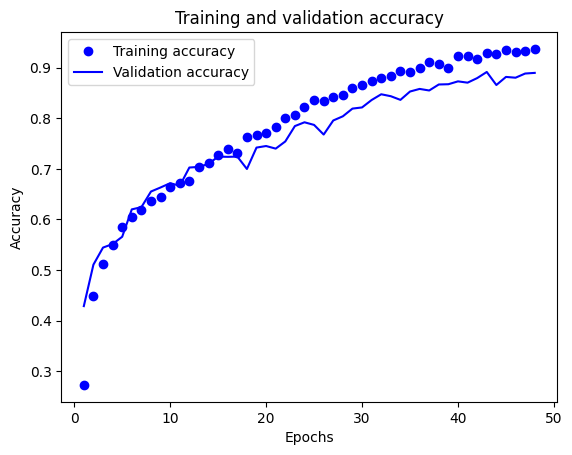

In [5]:

import matplotlib.pyplot as plt

def draw_history_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


draw_history_acc(history)

In [6]:
from sklearn.metrics import classification_report

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    y_test = encode_labels(y_test)

    print(classification_report(y_test, y_pred))

evaluate_model(model, X_test, y_test)


446/446 [==============================] - 25s 55ms/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      1617
           1       0.78      0.80      0.79      1415
           2       0.77      0.78      0.78      1479
           3       0.79      0.77      0.78      1498
           4       0.81      0.79      0.80      1372
           5       0.94      0.96      0.95      1467
           6       0.86      0.85      0.86      1305
           7       0.82      0.84      0.83      1369
           8       0.87      0.76      0.81      1406
           9       0.78      0.86      0.82      1344

    accuracy                           0.84     14272
   macro avg       0.84      0.83      0.83     14272
weighted avg       0.84      0.84      0.84     14272



In [5]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'filters': [32, 64, 128],
    'neurons': [32, 64, 128],
    'dropout': [0, 0.1, 0.2],
}

model = KerasClassifier(
    build_fn=build_model,
    verbose=VERBOSITY
)

grid_search_cv = GridSearchCV(
    model,
    param_grid=param_grid,
    verbose=VERBOSITY,
    cv=4
)

grid_result = grid_search_cv.fit(X_train, y_train)

print(grid_result.best_score_)

pprint.pprint(
    grid_result.best_params_,
    width=1
)


/tmp/ipykernel_12576/2113864958.py:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(


Fitting 4 folds for each of 27 candidates, totalling 108 fits


2023-04-16 10:00:24.668727: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 763297792 exceeds 10% of free system memory.


122/122 [==============================] - 7s 58ms/step - loss: 1.6610 - accuracy: 0.3948


2023-04-16 10:02:35.305083: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 763297792 exceeds 10% of free system memory.


122/122 [==============================] - 7s 57ms/step - loss: 1.4467 - accuracy: 0.4715


2023-04-16 10:04:51.124379: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 763363328 exceeds 10% of free system memory.


122/122 [==============================] - 7s 53ms/step - loss: 1.3971 - accuracy: 0.4969


2023-04-16 10:06:50.753679: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 763363328 exceeds 10% of free system memory.


122/122 [==============================] - 14s 110ms/step - loss: 1.2874 - accuracy: 0.5332


486/486 [==============================] - 137s 279ms/step - loss: 1.6413 - accuracy: 0.4077
0.542177751660347
{'dropout': 0.1,
 'filters': 32,
 'neurons': 64}


In [15]:

from keras.preprocessing.image import ImageDataGenerator

model_best = build_model(**grid_result.best_params_)

datagen_augment = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
)


history_best = fit_model(
    model_best,
    datagen_augment,
    X_train,
    y_train,
    X_val,
    y_val
)

Epoch 1/100


2023-04-16 18:54:27.387323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


121/121 [==============================] - 67s 544ms/step - loss: 2.1263 - accuracy: 0.2043 - val_loss: 1.9073 - val_accuracy: 0.2951
Epoch 2/100
121/121 [==============================] - 65s 533ms/step - loss: 1.9059 - accuracy: 0.2905 - val_loss: 1.7769 - val_accuracy: 0.3281
Epoch 3/100
121/121 [==============================] - 65s 536ms/step - loss: 1.8421 - accuracy: 0.3095 - val_loss: 1.7069 - val_accuracy: 0.3688
Epoch 4/100
121/121 [==============================] - 65s 535ms/step - loss: 1.7658 - accuracy: 0.3371 - val_loss: 1.7570 - val_accuracy: 0.3402
Epoch 5/100
121/121 [==============================] - 65s 536ms/step - loss: 1.7586 - accuracy: 0.3339 - val_loss: 1.6680 - val_accuracy: 0.3657
Epoch 6/100
121/121 [==============================] - 66s 546ms/step - loss: 1.7199 - accuracy: 0.3529 - val_loss: 1.6674 - val_accuracy: 0.3693
Epoch 7/100
121/121 [==============================] - 64s 532ms/step - loss: 1.6983 - accuracy: 0.3600 - val_loss: 1.6371 - val_accurac

Epoch 57/100
121/121 [==============================] - 66s 544ms/step - loss: 1.3841 - accuracy: 0.4715 - val_loss: 1.3521 - val_accuracy: 0.4844
Epoch 58/100
121/121 [==============================] - 63s 517ms/step - loss: 1.3900 - accuracy: 0.4645 - val_loss: 1.3122 - val_accuracy: 0.4965
Epoch 59/100
121/121 [==============================] - 65s 537ms/step - loss: 1.3845 - accuracy: 0.4743 - val_loss: 1.4202 - val_accuracy: 0.4710
Epoch 60/100
121/121 [==============================] - 64s 525ms/step - loss: 1.3799 - accuracy: 0.4735 - val_loss: 1.3420 - val_accuracy: 0.4836
Epoch 61/100
121/121 [==============================] - 65s 534ms/step - loss: 1.3922 - accuracy: 0.4709 - val_loss: 1.3302 - val_accuracy: 0.4857
Epoch 62/100
121/121 [==============================] - 65s 538ms/step - loss: 1.3708 - accuracy: 0.4718 - val_loss: 1.3291 - val_accuracy: 0.4932
Epoch 63/100
121/121 [==============================] - 66s 546ms/step - loss: 1.3735 - accuracy: 0.4753 - val_loss: 1

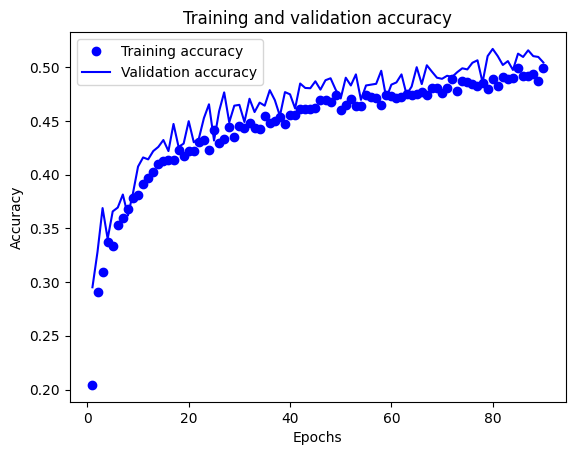

In [16]:
draw_history_acc(history_best)

In [18]:
from sklearn.metrics import classification_report

evaluate_model(model_best, X_test, y_test)

446/446 [==============================] - 28s 62ms/step
              precision    recall  f1-score   support

           0       0.64      0.70      0.67      1617
           1       0.44      0.44      0.44      1415
           2       0.37      0.33      0.35      1479
           3       0.36      0.31      0.33      1498
           4       0.51      0.44      0.47      1372
           5       0.69      0.82      0.75      1467
           6       0.55      0.67      0.61      1305
           7       0.46      0.56      0.50      1369
           8       0.36      0.45      0.40      1406
           9       0.43      0.17      0.25      1344

    accuracy                           0.49     14272
   macro avg       0.48      0.49      0.48     14272
weighted avg       0.48      0.49      0.48     14272



### Questions
1. What preprocessing techniques did you use? Why?
    - Scale image standartized size - 128x128
    - Convert each pixel's value to value in range \[0, 255\], which represents its darkness
2. What data augmentation techniques did you use?
    - Randomly:
        - Rotate image up to 10 degree
        - Flip image along vertical axis (horizontally)
        - Move image by x or y up to 10%
3. Describe the fine-tuning process and how you reached your final CNN model.
    - I derived the most valuable hyperparameters of CNN:
        - Max filters count
        - Dense layer's neurons count
        - Dropout layer's probability
    - I also used "adam" optimizer to tune learning rate
4. What techniques did you use to improve model’s performance other than data augmentation
    - *Answer*

# Task 3: Credit approval (15 points)

Credit approval is necessary to assess an individual's creditworthiness and determine their eligibility for loans, credit cards, and other financial products. It helps lenders to evaluate the borrower's ability to repay the loan, their credit history, and other financial obligations.
Credit approval is important for both lenders and borrowers because it enables lenders to manage their risk and make informed lending decisions while ensuring that borrowers can obtain financing on fair and reasonable terms.

In many credit approval applications, it is crucial for the model to be interpretable. This means that the model's inner workings and decision-making process can be easily understood and explained by humans. An interpretable model can help to build trust in the model's output, provide transparency in the decision-making process, and enable regulators to monitor and audit the model's performance. 

## What you need to do

For the `loan_data.csv` data, predict if the bank should give a loan or not.

- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Learning Objectives

- Apply DTs, and RFs to solve a classification problem (basic training, validation, testing. 50%
- Fine-tune to determine the optimal model architecture. 20%
- Evaluate and compare the performance of different models. 10%
- Visualise the models. 20%


### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

In [ ]:
# TODO: Implement task 3

### Questions
1. How did the DT compare to the RF in performance? Why?
    - *Answer*
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - *Answer*
3. What is ensemble learning? What are its pros and cons?
    - *Answer*
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    - *Answer*